## Load user rating file, covert the rating file into user-item matrix

In [1]:
import numpy as np
import pandas as pd

ratingfile = '/Users/yumei/Downloads/CSE575 machine learning/project/data/ml-100k/u.data'
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv(ratingfile, sep='\t', names=header)

n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

user_item_matrix = np.zeros((n_users, n_items))
for line in df.itertuples():
    user_item_matrix[line[1] - 1, line[2] - 1] = line[3]

Number of users = 943 | Number of movies = 1682


## Split the user-item matrix set into training set and testing set

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation as cv

# split the data set into training set and testing set
train_data, test_data = cv.train_test_split(df, test_size=0.25)

# transfer the train set and test set of ratings to user-item matrix
    
train = pd.DataFrame(train_data)
test = pd.DataFrame(test_data)

train_matrix = np.zeros((n_users, n_items))
for line in train.itertuples():
    train_matrix[int(line[1]) - 1, int(line[2]) - 1] = line[3]

test_matrix = np.zeros((n_users, n_items))
for line in test.itertuples():
    test_matrix[int(line[1]) - 1, int(line[2]) - 1] = line[3]  

## Compute the Rooted mean square error to evaluate the accuaracy

In [3]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(pred_rate, true_rate):
    prediction = pred_rate[true_rate.nonzero()].flatten() 
    true_rate = true_rate[true_rate.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, true_rate))


## Use Singular value decomposition (SVD) for matrix factorization 

In [4]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
def svd(train_matrix,test_matrix, factor_k):
    user, s, item = svds(train_matrix, k = factor_k)
    s_diag_matrix = np.diag(s)
    pred_rate = np.dot(np.dot(user, s_diag_matrix), item)
    rmse_s = 0
    rmse_s = rmse(pred_rate, test_matrix)
    print(rmse_s)
    return rmse_s

In [30]:
rmse_svd = []
for i in  range(1,11):
    k = i * 5
    rmse_s = svd(train_matrix,test_matrix, k)
    rmse_svd.append(rmse_s)

print(rmse_svd)

2.7382781856269576
2.672262786692225
2.6801155020743286
2.7120490114840234
2.750287870886201
2.7895267445325045
2.8337871040874996
2.872999629555222
2.9100687009386483
2.946528616588253
[2.7382781856269576, 2.672262786692225, 2.6801155020743286, 2.7120490114840234, 2.750287870886201, 2.7895267445325045, 2.8337871040874996, 2.872999629555222, 2.9100687009386483, 2.946528616588253]


## Get the index for the non-zero rating in training and testing user-item matrix 

In [5]:
# Index matrix for training data
train_ind = train_matrix.copy()
train_ind[train_ind > 0] = 1
train_ind[train_ind == 0] = 0

# Index matrix for test data
test_ind = test_matrix.copy()
test_ind[test_ind > 0] = 1
test_ind[test_ind == 0] = 0

## Prediction function

In [12]:
# Predict the unknown ratings through the dot product of the latent features for users and items and the bais
def prediction_sgd_bais(P, Q, b_global, b_user, b_item):
    ratings = np.dot(P, Q.T)
    for u in range(len(b_user)):
        for i in range(len(b_item)):
            ratings[u][i] = b_global +  b_user[u] + b_item[i] + ratings[u][i]
    return ratings

## Rooted mean square error computation function

In [17]:
# Calculate the RMSE for SGD
def als_sgd_rmse(ind, data_matrix, P, Q):
    return np.sqrt(np.sum((ind * (data_matrix - np.dot(P, Q.T)))**2)/len(data_matrix[data_matrix > 0]))

# Calculate the RMSE for ALS
def als_als_rmse(ind, data_matrix, P, Q):
    return np.sqrt(np.sum((ind * (data_matrix - np.dot(P.T,Q)))**2)/len(data_matrix[data_matrix > 0]))

# Calculate the RMSE for SGD with bias
def sgd_bais_rmse(ind, data_matrix, P, Q, b_global, b_user, b_item):
    return np.sqrt(np.sum((ind * (data_matrix - prediction_sgd_bais(P, Q, b_global, b_user, b_item)))**2)/len(data_matrix[data_matrix > 0]))

## Stochastic Gradient Descent(SGD) function

In [8]:
def sgd(train, test, train_ind, test_ind, factor_k, gamma, lmbda, iteration):
    print ("computing using SGD .....")
    
    train_errors = []
    test_errors = []

    m, n = train.shape # Number of users and items in training set

    # initialize Latent user feature matrix and Latent movie feature matrix
    P = 3 * np.random.rand(m,factor_k)  # Latent user feature matrix
    Q = 3 * np.random.rand(n,factor_k)  # Latent movie feature matrix

    # Only consider non-zero matrix
    users, items = train.nonzero()
    for iter in range(iteration):
        for u, i in zip(users, items):
            e = train[u, i] - prediction(P[u], Q[i])  # Calculate error for gradient
            P[u] += gamma * (e * Q[i] - lmbda * P[u])  # Update latent user feature matrix
            Q[i] += gamma * (e * P[u] - lmbda * Q[i])  # Update latent movie feature matrix
        train_rmse = als_sgd_rmse(train_ind, train, P, Q)  # Calculate root mean squared error from train dataset
        test_rmse = als_sgd_rmse(test_ind, test, P, Q)  # Calculate root mean squared error from test dataset
        train_errors.append(train_rmse)
        test_errors.append(test_rmse)

    return train_errors, test_errors

## predict using SGD method

In [52]:
factor_k = 20 # number of latent features
gamma = 0.01 # Learning rate
lmbda = 0.1 # Regularisation weight
iteration = 100 # number of iteration
# use stochastic gradient descent to optimize the prediction
train_errors_sgd, test_errors_sgd = sgd(train_matrix, test_matrix, train_ind, test_ind, factor_k, gamma, lmbda, iteration)

computing using SGD .....


In [59]:
print(test_errors_sgd[90:100])

[0.99368643895733777, 0.99337123085376389, 0.99306487449245051, 0.99276701676401413, 0.99247732058341342, 0.99219546404753389, 0.99192113965118867, 0.99165405355600467, 0.99139392490724731, 0.99114048519419251]


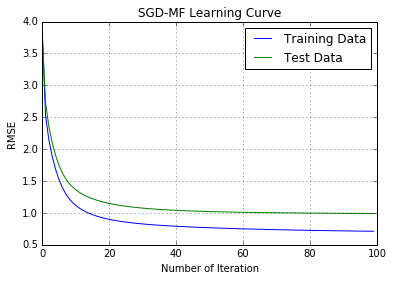

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

# Check performance by plotting train and test errors
plt.plot(range(100), train_errors_sgd, linestyle='-', label='Training Data')
plt.plot(range(100), test_errors_sgd, linestyle='-', label='Test Data')
plt.title('SGD-MF Learning Curve')
plt.xlabel('Number of Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

## Matrix factoriztion with bais(SGD)

In [41]:
def sgd_bais(train, test, train_ind, test_ind, factor_k, gamma, lmbda, iteration):
    print ("computing using SGD .....")
    
    train_errors = []
    test_errors = []

    m, n = train.shape # Number of users and items in training set

    # initialize Latent user feature matrix and Latent movie feature matrix
    P = 3 * np.random.rand(m,factor_k)  # Latent user feature matrix
    Q = 3 * np.random.rand(n,factor_k)  # Latent movie feature matrix
    
    # initilize the global mean rating,
    b_global = train.sum()/np.count_nonzero(train)
    
    # initilize user mean ratings bais
    b_user = []
    mean_user = 0
    for user in range(m):
        user_ratings = train[user]
        if np.count_nonzero(user_ratings):
            mean_user = user_ratings.sum()/np.count_nonzero(user_ratings) - b_global
        b_user.append(mean_user)
    
    # initilize item mean ratings bais
    b_item = []
    mean_item = 0
    for item in range(n):
        item_ratings = train[:,item]
        if np.count_nonzero(item_ratings):
            mean_item = item_ratings.sum()/np.count_nonzero(item_ratings) - b_global            
        b_item.append(mean_item)
    

    # Only consider non-zero matrix
    users, items = train.nonzero()
    for iter in range(iteration):
        for u, i in zip(users, items):
            e = train[u, i] - (np.dot(P[u], Q[i].T) + b_global + b_user[u] + b_item[i])   # Calculate error for gradient
            P[u] += gamma * (e * Q[i] - lmbda * P[u])  # Update latent user feature matrix
            Q[i] += gamma * (e * P[u] - lmbda * Q[i])  # Update latent movie feature matrix
            b_user[u] += gamma * (e  - lmbda * b_user[u])  # Update user mean ratings bais
            b_item[i] += gamma * (e  - lmbda *b_item[i])  # Update item mean ratings bais
            b_global += gamma * (e  - lmbda *b_global)  # Update global mean rating
        train_rmse = sgd_bais_rmse(train_ind, train, P, Q, b_global, b_user, b_item)  # Calculate root mean squared error from train dataset
        test_rmse = sgd_bais_rmse(test_ind, test, P, Q, b_global, b_user, b_item)  # Calculate root mean squared error from test dataset
        train_errors.append(train_rmse)
        test_errors.append(test_rmse)

    return train_errors, test_errors

## predict using Stochatic Gradient Descent with bais

In [48]:
factor_k = 20 # number of latent features
gamma = 0.01 # Learning rate
lmbda = 0.1 # Regularisation weight
iteration = 100 # number of iteration
# use stochastic gradient descent to optimize the prediction
train_errors_sgd_bais, test_errors_sgd_bais = sgd_bais(train_matrix, test_matrix, train_ind, test_ind, factor_k, gamma, lmbda, iteration)


computing using SGD .....


In [49]:
print(test_errors_sgd_bais[90:100])

[0.95738986227393519, 0.95705193197721095, 0.95672378678091186, 0.95640507583907719, 0.95609546205378249, 0.95579462149051209, 0.9555022428285177, 0.95521802684269541, 0.95494168591390838, 0.95467294356500265]


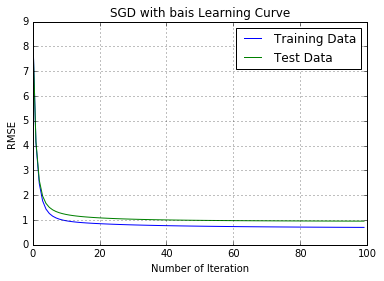

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(100), train_errors_sgd_bais, linestyle='-',  label='Training Data')
plt.plot(range(100), test_errors_sgd_bais, linestyle='-', label='Test Data')
plt.title('SGD with bais Learning Curve')
plt.xlabel('Number of Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

## Alternating Least Square (ALS) function

In [18]:
def als(train, test, train_ind, test_ind, factor_k, lmbda, iteration):
    
    train_errors = []
    test_errors = []

    m, n = train.shape  # Number of users and items in training set

    # initialize Latent user feature matrix and Latent movie feature matrix
    P = 3 * np.random.rand(factor_k,m)  # Latent user feature matrix
    Q = 3 * np.random.rand(factor_k,n)  # Latent movie feature matrix
    
    Q[:,0] = train[train != 0].mean(axis=0) # Avg. rating for each movie
    E = np.eye(factor_k) # (k x k)-dimensional idendity matrix
    
    for iter in range(iteration):
        print ("computing using ALS .....")
        # fix Latent movie feature matrix(Q), optimize Latent user feature matrix(P)
        for i, Ii in enumerate(train_ind):
            nui = np.count_nonzero(Ii) # Number of items user i has rated
            if (nui == 0): nui = 1 # Be aware of zero counts!
    
            # Least squares solution
            Ai = np.dot(Q, np.dot(np.diag(Ii), Q.T)) + lmbda * nui * E
            Vi = np.dot(Q, np.dot(np.diag(Ii), train[i].T))
            P[:,i] = np.linalg.solve(Ai,Vi)

        # fix Latent user feature matrix(P), optimize Latent movie feature matrix(Q)
        for j, Ij in enumerate(train_ind.T):
            nmj = np.count_nonzero(Ij) # Number of users that rated item j
            if (nmj == 0): nmj = 1 # Be aware of zero counts!
        
            # Least squares solution
            Aj = np.dot(P, np.dot(np.diag(Ij), P.T)) + lmbda * nmj * E
            Vj = np.dot(P, np.dot(np.diag(Ij), train[:,j]))
            Q[:,j] = np.linalg.solve(Aj,Vj)

        train_rmse = als_als_rmse(train_ind, train, P, Q)  # Calculate root mean squared error from train dataset
        test_rmse = als_als_rmse(test_ind, test, P, Q)  # Calculate root mean squared error from test dataset
        train_errors.append(train_rmse)
        test_errors.append(test_rmse)

    return train_errors, test_errors

## Predict the rating and compute the RMSE using the three different matrix factorization methods SVD, SGD, ALS. 

In [19]:
factor_k = 20 # number of latent features
gamma = 0.01 # Learning rate
lmbda = 0.1 # Regularisation weight
iteration = 15 # number of iteration

# use the alternating least squares to to optimize the prediction
train_errors_als, test_errors_als = als(train_matrix, test_matrix, train_ind, test_ind, factor_k, lmbda, iteration)

computing using ALS .....
computing using ALS .....
computing using ALS .....
computing using ALS .....
computing using ALS .....
computing using ALS .....
computing using ALS .....
computing using ALS .....
computing using ALS .....
computing using ALS .....
computing using ALS .....
computing using ALS .....
computing using ALS .....
computing using ALS .....
computing using ALS .....


In [21]:
print("ALS: ", train_errors_als)
print("ALS test: ", test_errors_als)

ALS:  [1.2931642900231697, 0.95205223690057916, 0.82796309362575515, 0.76868270049910459, 0.73547279723283221, 0.71493075694768649, 0.70136014375445443, 0.69192228874119155, 0.68507388342581554, 0.67992974372707393, 0.67595843914427467, 0.67282634624811311, 0.67031444007507957, 0.66827269243829723, 0.66659439588891134]
ALS test:  [1.4070488304831923, 1.1325381928759248, 1.0481268062356446, 1.0074370585885268, 0.9842763981861351, 0.96967495444194018, 0.9599001093363031, 0.9531269636799754, 0.94832334918634786, 0.9448522368473361, 0.94230075383727374, 0.94039276437425168, 0.93893923980322436, 0.93780949557169524, 0.93691367621536292]


## Plot the learning curve of RMSE based on ALS method

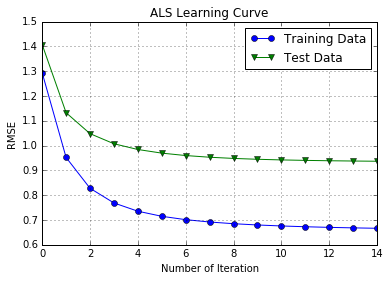

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(iteration), train_errors_als, marker='o', label='Training Data')
plt.plot(range(iteration), test_errors_als, marker='v', label='Test Data')
plt.title('ALS Learning Curve')
plt.xlabel('Number of Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()